In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import frame as fr
import algo_result as alg_res
import os
from sklearn import preprocessing
from scipy.fft import fft, fftn, fftfreq, fftshift
from scipy.signal import spectrogram
%run algo_process.ipynb


In [2]:
def peak_search_dopp(spectrum,Lo_thresh,Hi_thresh,peak_relevance):
    counter = 0
    peak_strength = np.max(spectrum)
    peak_bin = np.argmax(spectrum)
    doppler_details = {"peak_count":0,"total_harmonic_relative_strength":0,"peak_bin":[],"harmonic_relative_strength":[],"max_peak_strength":peak_strength}
    harmonic_strength = 0
    fbc = 2
    fbl2 = fbc - 2
    fbl1 = fbc - 1
    fbr1 = fbc + 1
    fbr2 = fbc + 2
    for idx in range(len(spectrum)):
        if fbr2 >= len(spectrum):
            continue
        pvl2 = spectrum[fbl2]
        pvl1 = spectrum[fbl1]
        pvc = spectrum[fbc]
        pvr1 = spectrum[fbr1]
        pvr2 = spectrum[fbr2]
        if pvl2+peak_relevance < pvl1 and pvr1 > pvr2+peak_relevance and pvc > Lo_thresh and pvc < Hi_thresh and pvc >= pvl1 and pvc >= pvr1 and fbc != peak_bin:
            harmonic_strength += pvc[0]
            counter += 1
            doppler_details["peak_bin"].append(fbc)
            doppler_details["harmonic_relative_strength"].append(pvc/peak_strength)
        fbc += 1
        fbl2 = fbc - 2
        fbl1 = fbc - 1
        fbr1 = fbc + 1
        fbr2 = fbc + 2
    doppler_details["peak_count"] = counter
    doppler_details["total_harmonic_relative_strength"] = harmonic_strength/peak_strength
    return doppler_details

In [3]:
SAMPLES_PER_CHIRP = 64
CHIRPS_PER_FRAME = 128
T = 300e-6
SPEED_OF_LIGHT = 3e8
START_FREQUENCY = 24.025e9
B = 200e6
PULSE_REPETITION_INTERVAL = 500e-6
SAMPLE_PERIOD = T/SAMPLES_PER_CHIRP
SAMPLE_FREQUENCY = 1/SAMPLE_PERIOD
LAMBDA = SPEED_OF_LIGHT/START_FREQUENCY
RANGE_PAD = 256
DOPPLER_PAD = 512
ANTENNA_SPACING = 6.22e-3

PEAK_THRESHOLD = 0.005 # normalized FFT absolute minimum strength 
PEAK_SLICE = 2 #meters around target
PEAK_WIDTH = 1 #integer
PEAK_RELEVANCE = 0 #minimum distance between pvl1,pvr1 and pvc
SEARCH_ZONE = 25 #split spectrum in slices of SEARCH_ZONE meters to find a single peak
MIN_DIST = 5 #minimum distance for detection

ANGLE_CALIBRATION = -150
ANGLE_PRECISION = 1

ANTENNA_NUMBER = 1

FRAME_REP_INTERVAL = 0.2

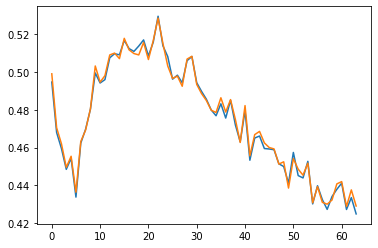

In [4]:
calibration_data = pd.read_csv('../../data/Dataset_1/environment_1.txt', sep='\t', header=None)
calibration = calibration_data.select_dtypes(include = ['float']).values
CALIBRATION_FRAME_NUMBER = len(calibration)//(SAMPLES_PER_CHIRP*CHIRPS_PER_FRAME)
calibration_frames = []
###Create dataset
for frame in range(CALIBRATION_FRAME_NUMBER):
    calibration_frames.append(fr.Frame(calibration[frame*CHIRPS_PER_FRAME*SAMPLES_PER_CHIRP:(frame+1)*CHIRPS_PER_FRAME*SAMPLES_PER_CHIRP,:],\
                           SAMPLES_PER_CHIRP, CHIRPS_PER_FRAME, ANTENNA_NUMBER, T))
    
average_calib_chirp = np.zeros((SAMPLES_PER_CHIRP,ANTENNA_NUMBER),dtype=complex)
for frame in range(1):
    for chirp in range(CHIRPS_PER_FRAME):
        average_calib_chirp += calibration_frames[frame].get_chirp(chirp)
        
average_calib_chirp /= CHIRPS_PER_FRAME
#averaged
#plt.plot(np.real(average_calib_chirp))
plt.plot(np.imag(average_calib_chirp))
#non averaged
#plt.plot(np.real(calibration_frames[20].chirp[:,:,50]))
plt.plot(np.imag(calibration_frames[0].chirp[:,:,0]))
plt.show()

../../data/Dataset_1/walking_boresight_1.txt


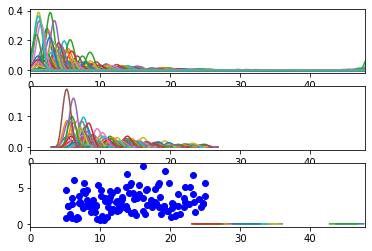

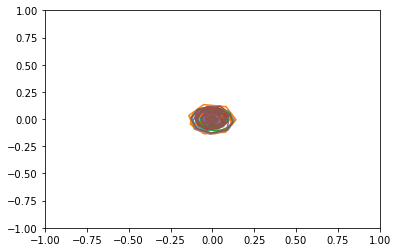

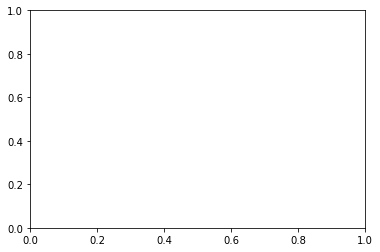

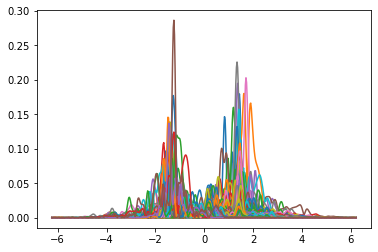

(512, 300)
(27, 109)


<ipython-input-5-be1aac8a6034>:196: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Target_statistics = np.append(Target_statistics,np.array(feature).reshape(1,-1),axis=0)


In [5]:
directory = os.fsencode('../../data/Dataset_1/')

actual_filename = []
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    #(filename.startswith('biking_mixed') or filename.startswith('walking_mixed'))
    # and filename.startswith('biking_boresight_128_test_1')  and filename.startswith('walking_test_1')
    if filename != 'environment_test_1.txt' and filename.endswith('.txt') and filename.find('walking_boresight_1')!=-1:
        actual_filename = filename
        path = os.path.join(os.fsdecode(directory), filename)
        print(path)                    
        data = pd.read_csv(path, sep='\t', header=None)
        data.columns = ["idx","I_RX1","Q_RX1"]
        
        recording = data.select_dtypes(include = ['float']).values
        FRAME_NUMBER = len(data)//(SAMPLES_PER_CHIRP*CHIRPS_PER_FRAME)
        Hu_bi_frame = []
        ###Create dataset
        for frame in range(FRAME_NUMBER):
            Hu_bi_frame.append(fr.Frame(recording[frame*CHIRPS_PER_FRAME*SAMPLES_PER_CHIRP:(frame+1)*CHIRPS_PER_FRAME*SAMPLES_PER_CHIRP,:],\
                                   SAMPLES_PER_CHIRP, CHIRPS_PER_FRAME, ANTENNA_NUMBER, T)) 
        ###Calibrate frames
        calibrate = True
        if calibrate:
            for frame in range(FRAME_NUMBER):
                Hu_bi_frame[frame].calibrate(average_calib_chirp)

        xf = np.arange(0,RANGE_PAD)
        range_bin = xf*T*SPEED_OF_LIGHT/(2*B)/(T/SAMPLES_PER_CHIRP)/RANGE_PAD
        range2bin = 1/(T/SAMPLES_PER_CHIRP)/RANGE_PAD*T*SPEED_OF_LIGHT/(2*B)
        vel_bin = fftshift(fftfreq(DOPPLER_PAD,PULSE_REPETITION_INTERVAL))*SPEED_OF_LIGHT/(2*START_FREQUENCY) 

        Target_observations = []
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
        ax1.set_xlim(range_bin[0],range_bin[-1])
        ax2.set_xlim(range_bin[0],range_bin[-1])
        ax3.set_xlim(range_bin[0],range_bin[-1])
        fig, ax4 = plt.subplots(1, 1)
        fig, ax5 = plt.subplots(1, 1)
        fig, ax6 = plt.subplots(1, 1)
        ax4.set_xlim(-1,1)
        ax4.set_ylim(-1,1)
        Range_spectrum_history = []
        Target_info_list = []
        Target_presence_list = []
        
        PLOT = True
        ###Process frames
        for frame in range(FRAME_NUMBER):
            data_out,target_info, MTI_out = algo_process(Hu_bi_frame[frame],RANGE_PAD,CHIRPS_PER_FRAME,DOPPLER_PAD,PEAK_THRESHOLD,PEAK_SLICE,PEAK_WIDTH,PEAK_RELEVANCE,SEARCH_ZONE,ANGLE_CALIBRATION,ANGLE_PRECISION,round(LAMBDA/ANTENNA_SPACING),range2bin)
            Range_spectrum_history.append(MTI_out)
            if(target_info.num_targets > 0 and target_info.location[0] < SEARCH_ZONE and target_info.location[0] > MIN_DIST):
                Target_info_list.append(target_info)
                Target_presence_list.append(1)
            else:
                Target_presence_list.append(0)  
            ax1.plot(range_bin,MTI_out)
            if PLOT:
                for target in range(target_info.num_targets):
                    if target_info.location[target] < SEARCH_ZONE and target_info.location[0] > MIN_DIST:
                        ax3.plot(target_info.location[target], target_info.strength[target]*target_info.location[target]**2,'bo')
                        ax2.plot(target_info.print_location[:,target],target_info.print[:,0,target])
                        ax4.plot(np.real(target_info.doppler_mark[:,target]),np.imag(target_info.doppler_mark[:,target]))
                        #ax5.plot(target_info.angle,target_info.angle_spectrum[:,target])
                        ax6.plot(vel_bin,target_info.doppler_spectrum[:,target])
                        #Target_observations.append(np.append(target_info.print[:,:,target].T,target_info.location[target]))
                    elif target_info.location[target] > SEARCH_ZONE:
                        ax3.plot(target_info.print_location[:,target],target_info.print[:,0,target])
        
        plt.show()
        
        
        ###Feature extraction
        target_doppler_spec = np.zeros((DOPPLER_PAD,1))
        idx = 0

        weighted_avg = []
        weighted_std = []
        location = []
        strength = []
        dB_Hi = 15
        T_Hi_thr = np.power(10,dB_Hi/20)
        dB_Mi = 30
        T_Mi_thr = np.power(10,dB_Mi/20)
        dB_Lo = 44
        T_Lo_thr = np.power(10,dB_Lo/20)
        SPC_Hi = []
        SPD = []
        SPC_Lo = []
        SPC_Mi = []
        MDR = []
        maximum_deviation = []
        Hi_peak_count = []
        Lo_peak_count = []
        std_deviation = []
        Hi_harmonic_power_content = []
        Lo_harmonic_power_content = []
        frame_counter = []
        correlation = []
        max_to_mean_distance = []
        peak_strength_std = []
        Lo_skewness = []
        Lo_skewness_variation = []
        Hi_deviation = []
        Hi_deviation_difference = []
        Mi_peak_count = []
        Mi_harmonic_power_content = []
        Mi_skewness = []
        Mi_deviation_difference = []
        counter = 0
        
        all_features = [location,weighted_avg,weighted_std,SPC_Hi,SPD,MDR,strength,maximum_deviation,SPC_Lo,Hi_peak_count,\
                       std_deviation,Hi_harmonic_power_content,frame_counter,correlation,max_to_mean_distance,peak_strength_std,\
                       Lo_peak_count,Lo_harmonic_power_content,SPC_Mi,Lo_skewness,Lo_skewness_variation,Hi_deviation,\
                       Hi_deviation_difference, Mi_peak_count, Mi_harmonic_power_content, Mi_skewness, Mi_deviation_difference]

        previous_target_presence = 1 #to check for targets present in 2 subsequent frames
        subsequent_frames = 0
        for target_presence in Target_presence_list:
            counter +=1
            ###Use to cut pieces of recording
            #if counter > 140 and counter < 250:
            #    target_doppler_spec = np.append(target_doppler_spec, np.zeros((DOPPLER_PAD,1)), axis=1)
            #    continue
            if target_presence:
                next_dopp_spectrum = Target_info_list[idx].doppler_spectrum[:,0].reshape((DOPPLER_PAD,1))
                target_doppler_spec = np.append(target_doppler_spec,next_dopp_spectrum , axis=1)
                if previous_target_presence:
                    ###
                    location.append(Target_info_list[idx].location[0]/SEARCH_ZONE)
                    strength.append(sum(next_dopp_spectrum))
                    ###
                    length = len(next_dopp_spectrum)
                    max_peak = max(next_dopp_spectrum)
                    SPC_Hi_thresh = max_peak/T_Hi_thr
                    SPC_Mi_thresh = max_peak/T_Mi_thr
                    SPC_Lo_thresh = max_peak/T_Lo_thr
                    weighted_avg.append(sum([i*next_dopp_spectrum[i] for i in range(length)])/sum(next_dopp_spectrum[:]))
                    tmp_roll = np.roll(next_dopp_spectrum,DOPPLER_PAD//2-round(weighted_avg[subsequent_frames][0]))
                    weighted_std.append(np.sqrt(sum([(i-DOPPLER_PAD//2)**2*tmp_roll[i] for i in np.arange(DOPPLER_PAD//4,3*DOPPLER_PAD//4)])/sum(tmp_roll[DOPPLER_PAD//4:3*DOPPLER_PAD//4])/(DOPPLER_PAD//4)**2))
                    SPC_Hi.append(sum([next_dopp_spectrum[i] > SPC_Hi_thresh for i in range(length)])/DOPPLER_PAD)
                    SPD.append(np.abs(SPC_Hi[subsequent_frames] - SPC_Hi[subsequent_frames-1]))
                    SPC_Lo.append(sum([(next_dopp_spectrum[i] > SPC_Lo_thresh and next_dopp_spectrum[i] <= SPC_Mi_thresh) for i in range(length)])/DOPPLER_PAD)
                    SPC_Mi.append(sum([(next_dopp_spectrum[i] > SPC_Mi_thresh and next_dopp_spectrum[i] <= SPC_Hi_thresh) for i in range(length)])/DOPPLER_PAD)
                    Gt = np.max(Target_info_list[idx].doppler_spectrum[:,0])/Target_info_list[idx].location[0]**2
                    Gt_prime = np.max(Target_info_list[idx-1].doppler_spectrum[:,0])/Target_info_list[idx-1].location[0]**2
                    MDR.append(np.abs(Gt - Gt_prime)/Gt )
                    ###
                    max_peak_bin = np.argmax(next_dopp_spectrum)
                    tmp_roll = np.roll(next_dopp_spectrum,DOPPLER_PAD//2-max_peak_bin)
                    maximum_deviation.append(np.sqrt(sum([(i-DOPPLER_PAD//2)**2*tmp_roll[i] for i in range(length)])/sum(next_dopp_spectrum[:])/DOPPLER_PAD**2))
                    ###High
                    doppler_details = peak_search_dopp(tmp_roll,SPC_Hi_thresh,np.Inf,0)
                    Hi_peak_count.append(doppler_details["peak_count"])
                    Hi_harmonic_power_content.append(doppler_details["total_harmonic_relative_strength"])
                    third_moment = np.sqrt(sum([(doppler_details["peak_bin"][i]-DOPPLER_PAD//2)**2*doppler_details["harmonic_relative_strength"][i] for i in range(len(doppler_details["peak_bin"]))])/(DOPPLER_PAD//2)**2)
                    Hi_deviation.append(third_moment)
                    Hi_deviation_difference.append(abs(Hi_deviation[subsequent_frames] - Hi_deviation[subsequent_frames-1]))
                    ###Mid
                    doppler_details = peak_search_dopp(tmp_roll,SPC_Mi_thresh,SPC_Hi_thresh,0)
                    Mi_peak_count.append(doppler_details["peak_count"])
                    Mi_harmonic_power_content.append(doppler_details["total_harmonic_relative_strength"])
                    third_moment = np.sqrt(sum([(doppler_details["peak_bin"][i]-DOPPLER_PAD//2)**2*doppler_details["harmonic_relative_strength"][i] for i in range(len(doppler_details["peak_bin"]))])/(DOPPLER_PAD//2)**2)
                    Mi_skewness.append(third_moment)
                    Mi_deviation_difference.append(abs(Hi_deviation[subsequent_frames] - Hi_deviation[subsequent_frames-1]))
                    ###Low
                    doppler_details = peak_search_dopp(tmp_roll,SPC_Lo_thresh,SPC_Mi_thresh,0)
                    Lo_peak_count.append(doppler_details["peak_count"])
                    Lo_harmonic_power_content.append(doppler_details["total_harmonic_relative_strength"])
                    skewness = abs(sum([(doppler_details["peak_bin"][i]-DOPPLER_PAD//2)**3*doppler_details["harmonic_relative_strength"][i] for i in range(len(doppler_details["peak_bin"]))])/(DOPPLER_PAD//2)**3)
                    Lo_skewness.append(skewness)
                    Lo_skewness_variation.append(abs(Lo_skewness[subsequent_frames] - Lo_skewness[subsequent_frames-1]))
                    #print(Lo_skewness[subsequent_frames])
                    ###
                    std_deviation.append(np.abs(weighted_std[subsequent_frames] - weighted_std[subsequent_frames-1]))
                    frame_counter.append(counter)
                    ###
                    correlation.append(sum(Target_info_list[idx].doppler_spectrum[:,0]*Target_info_list[idx-1].doppler_spectrum[:,0])/sum(Target_info_list[idx].doppler_spectrum[:,0])**2)
                    ###
                    max_to_mean_distance.append(np.abs(max_peak_bin-weighted_avg[subsequent_frames])/DOPPLER_PAD)
                    ###
                    peak_strength = np.max(Target_info_list[idx].print[:,:,0],axis=0)*Target_info_list[idx].location[0]**2
                    peak_strength_mean = np.sum(peak_strength)/CHIRPS_PER_FRAME
                    peak_strength_std.append(np.sqrt(np.sum((peak_strength-peak_strength_mean)**2)))
                    subsequent_frames += 1
                idx += 1
            else:
                target_doppler_spec = np.append(target_doppler_spec, np.zeros((DOPPLER_PAD,1)), axis=1)
            previous_target_presence = target_presence
        target_doppler_spec = target_doppler_spec[:,1:]
        print(target_doppler_spec.shape)
        ### SAVE STATS
        
        Target_statistics = np.empty((1,subsequent_frames))
        for feature in all_features:
            Target_statistics = np.append(Target_statistics,np.array(feature).reshape(1,-1),axis=0)
        Target_statistics = Target_statistics[1:,:]
        

        print(Target_statistics.shape)

        #df = pd.DataFrame(Target_statistics)
        #output_path = "../statistics_data_processing/data/"
        #output_filename = actual_filename.split('.')[0]+'_out'
        #extension = '_statistics.txt'
        #df.T.to_csv(output_path+output_filename+extension, sep='\t',index=False, header=False)
    

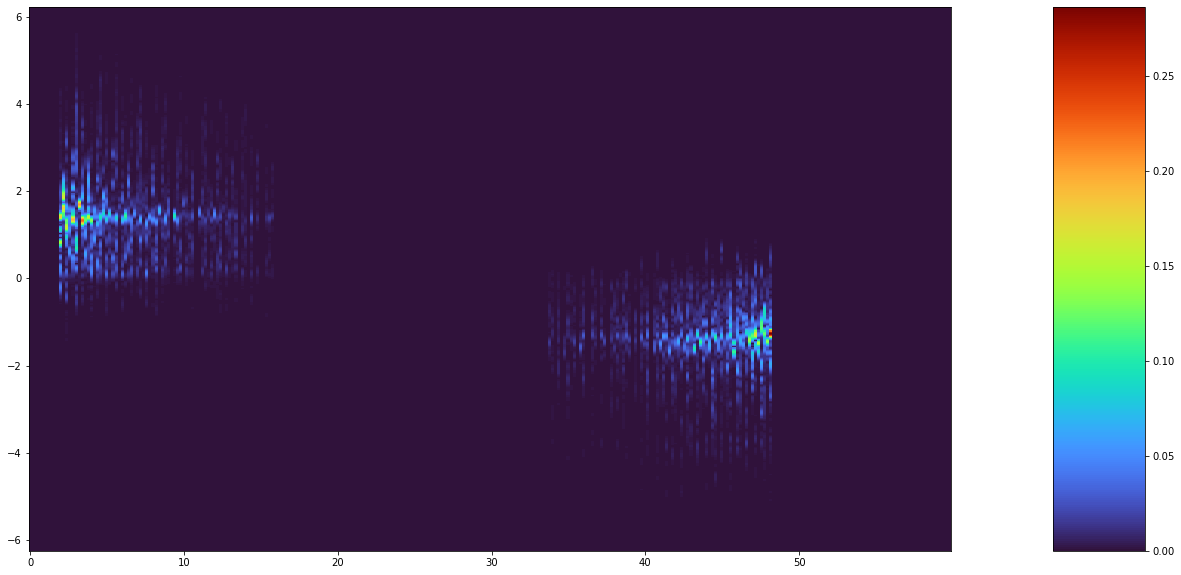

In [6]:
import matplotlib as mpl
### PLOT DOPPLER VS TIME
fig,[ax,cax] = plt.subplots(1,2, gridspec_kw={"width_ratios":[10,1]}, figsize=[20,10])
ax.clear()
cmap = mpl.cm.get_cmap('turbo')
norm = mpl.colors.Normalize(vmin=0, vmax=np.max(target_doppler_spec))
cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
levels = np.linspace(0.0, np.max(target_doppler_spec), 100)
ax.pcolormesh(np.arange(0,FRAME_NUMBER)*FRAME_REP_INTERVAL,vel_bin,target_doppler_spec, cmap=cmap, norm=norm, shading='nearest')
#plt.savefig('biking_mixed_test_1.png')
            

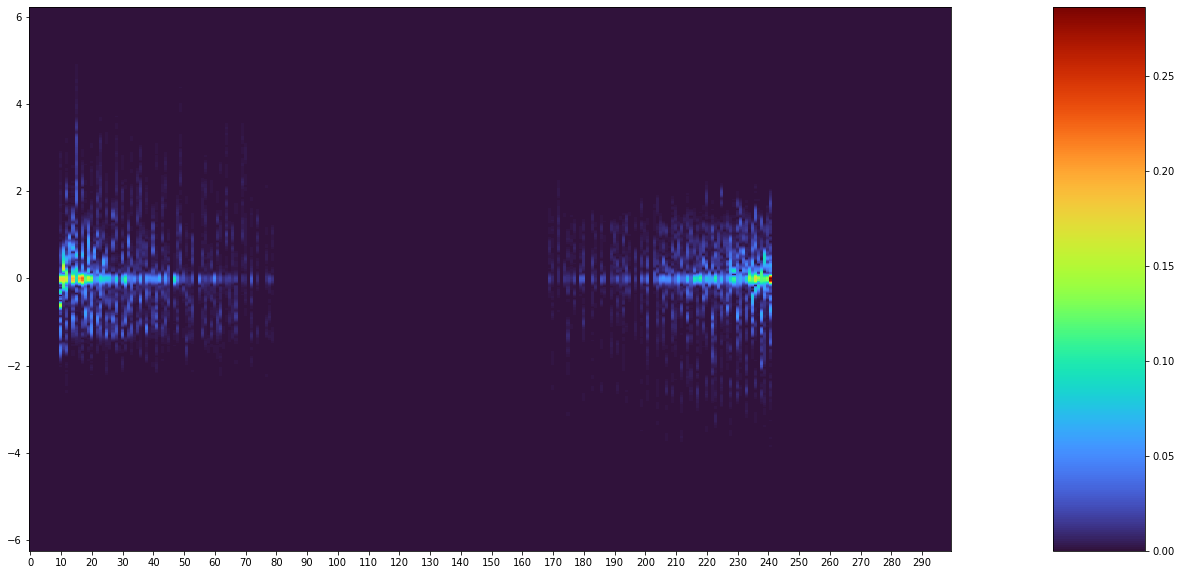

In [7]:
%matplotlib inline
rolled_doppler = np.zeros(target_doppler_spec.shape)

for frame in range(FRAME_NUMBER):
    if max(target_doppler_spec[:,frame]) > 0:
        max_idx = np.argmax(target_doppler_spec[:,frame])
        #round(sum([(i)*target_doppler_spec[i,frame] for i in range(DOPPLER_PAD)])/sum(target_doppler_spec[:,frame]))
        rolled_doppler[:,frame] = np.roll(target_doppler_spec[:,frame],(DOPPLER_PAD//2 - max_idx))

fig,[ax,cax] = plt.subplots(1,2, gridspec_kw={"width_ratios":[10,1]}, figsize=[20,10])
ax.clear()
cmap = mpl.cm.get_cmap('turbo')
norm = mpl.colors.Normalize(vmin=0, vmax=np.max(rolled_doppler))
cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
levels = np.linspace(0.0, np.max(rolled_doppler), 100)
ax.pcolormesh(np.arange(0,FRAME_NUMBER),vel_bin,rolled_doppler, cmap=cmap, norm=norm, shading='nearest')
#ax.contourf(np.arange(0,FRAME_NUMBER),vel_bin,rolled_doppler, levels, cmap=cmap, norm=norm)
_ = ax.set_xticks(np.arange(0,FRAME_NUMBER,10))
#plt.savefig('biking_boresight_test_1.png')

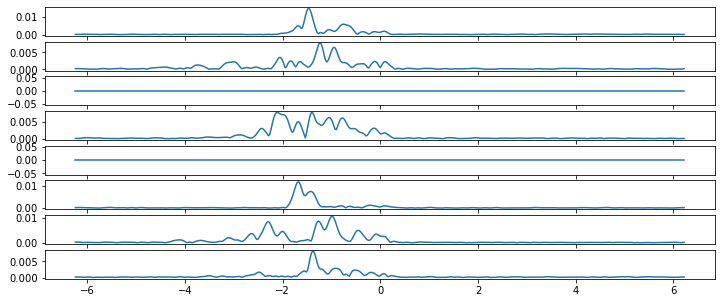

In [8]:
column_plots = 1
row_plots = 8
fig,ax = plt.subplots(row_plots,column_plots,figsize=[12,5])
from_second_number = 169#round(32/FRAME_REP_INTERVAL)
for col in range(column_plots):
    for row in range(row_plots):
        data = target_doppler_spec[:,row + row_plots*col + from_second_number].reshape((1,-1))[0,:]
        ax[row].plot(vel_bin,data)
plt.show()
correlation = sum(target_doppler_spec[:,from_second_number].reshape((1,-1))[0,:]*target_doppler_spec[:,from_second_number+1].reshape((1,-1))[0,:])

In [31]:
%matplotlib widget
fig,ax = plt.subplots(4,1, figsize=[12,5]) 
from_second_number = 169#round(32/FRAME_REP_INTERVAL)+5
#for frame in np.arange(from_second_number,from_second_number+1):
ax[0].plot(np.sum(target_doppler_spec[:,from_second_number:from_second_number+1],axis=1))
if(sum(target_doppler_spec[:,from_second_number:from_second_number+1][:] > 0)):
    actual_dopp = target_doppler_spec[:,from_second_number:from_second_number+1]
    weighted_avg_1 = sum([i*actual_dopp[i] for i in range(length)])/sum(actual_dopp[:])
    ax[0].plot(weighted_avg_1,np.max(actual_dopp),'ro')
    low_tresh = np.max(actual_dopp)/T_Lo_thr*np.ones(length)
    mid_tresh = np.max(actual_dopp)/T_Mi_thr*np.ones(length)
    high_tresh = np.max(actual_dopp)/T_Hi_thr*np.ones(length)
    ax[0].plot(low_tresh)
    ax[0].plot(mid_tresh)
    ax[0].plot(high_tresh)
    ax[0].set_ylim((0,high_tresh[0]*11/10))


    actual_dopp = np.roll(actual_dopp,DOPPLER_PAD//2 - round(weighted_avg_1[0]))
    ax[1].plot(actual_dopp)
    weighted_avg_1 = sum([i*actual_dopp[i] for i in range(length)])/sum(actual_dopp[:])
    ax[1].plot(DOPPLER_PAD//2,np.max(actual_dopp),'ro')
    ax[1].plot(low_tresh)
    ax[1].plot(mid_tresh)
    ax[1].plot(high_tresh)
    quadratic = []
    for i in range(DOPPLER_PAD):
        if i > 3*DOPPLER_PAD//8 and i < DOPPLER_PAD//2:
            quadratic.append(1-(i-7*DOPPLER_PAD//16)**2/(DOPPLER_PAD//16)**2)
        elif i > DOPPLER_PAD//2 and i < 5*DOPPLER_PAD//8:
            quadratic.append(1-(i-9*DOPPLER_PAD//16)**2/(DOPPLER_PAD//16)**2)
        else:
            quadratic.append(0)
            
    hor_quadratic = []
    for i in range(DOPPLER_PAD):
        if i > DOPPLER_PAD//4 and i < DOPPLER_PAD//2:
            hor_quadratic.append(np.sqrt((DOPPLER_PAD//2-i)/(DOPPLER_PAD//4)))
        elif i > DOPPLER_PAD//2 and i < 3*DOPPLER_PAD//4:
            hor_quadratic.append(np.sqrt((i-DOPPLER_PAD//2)/(DOPPLER_PAD//4)))
        else:
            hor_quadratic.append(0)
    
    
    ax[1].plot(np.array(quadratic)*np.max(actual_dopp))
    ax[1].plot(np.array(hor_quadratic)*np.max(actual_dopp))
    weighted_std_1 = ([quadratic[i]*actual_dopp[i] for i in np.arange(DOPPLER_PAD//4,3*DOPPLER_PAD//4)])/sum(tmp_roll[DOPPLER_PAD//4:3*DOPPLER_PAD//4])
    ax[2].plot(np.arange(0,len(weighted_std_1))+DOPPLER_PAD//4,weighted_std_1,'bo')
    #ax[]
    print(np.sqrt(sum(weighted_std_1)))
    print(round(weighted_avg_1[0]))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

[0.20897329]
249


In [10]:
def peak_search_details(spectrum,Lo_thresh,Hi_thresh,peak_relevance):
    counter = 0
    peak_power = np.max(spectrum)
    peak_bin = np.argmax(spectrum)
    harmonic_power = 0
    fbc = 2
    fbl2 = fbc - 2
    fbl1 = fbc - 1
    fbr1 = fbc + 1
    fbr2 = fbc + 2
    peak_info = {"peak_bin":[],"peak_strength":[],"max_peak_strength":peak_power}
    
    for idx in range(len(spectrum)):
        if fbr2 >= len(spectrum):
            continue
        pvl2 = spectrum[fbl2]
        pvl1 = spectrum[fbl1]
        pvc = spectrum[fbc]
        pvr1 = spectrum[fbr1]
        pvr2 = spectrum[fbr2]
        if pvl2+peak_relevance < pvl1 and pvr1 > pvr2+peak_relevance and pvc > Lo_thresh and pvc < Hi_thresh and pvc >= pvl1 and pvc >= pvr1 and fbc != peak_bin:
            peak_info["peak_bin"].append(fbc)
            peak_info["peak_strength"].append(pvc/peak_power)
        fbc += 1
        fbl2 = fbc - 2
        fbl1 = fbc - 1
        fbr1 = fbc + 1
        fbr2 = fbc + 2
    return peak_info
    

In [11]:
frame_doppler_peaks_dict = []
for target in Target_info_list:
    max_bin = np.argmax(target.doppler_spectrum[:,0])
    frame_doppler_peaks_dict.append(peak_search_details(np.roll(target.doppler_spectrum[:,0]*target.location[0]**2,DOPPLER_PAD//2 - max_bin),0,np.Inf,0))

In [12]:
%matplotlib widget
fig,ax = plt.subplots(1,1, figsize=[12,5]) 
all_doppler_peaks = np.array([])
for frame in frame_doppler_peaks_dict:
    all_doppler_peaks = np.append(all_doppler_peaks,np.array(frame["peak_strength"]))
n,bins=np.histogram(all_doppler_peaks,5000)
cumulative_n = [0]
for idx in range(len(n)):
    cumulative_n.append(n[idx] + cumulative_n[idx])
ax.plot(bins,cumulative_n/cumulative_n[-1])
ax.set_xlim((0,0.8))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(0.0, 0.8)

In [13]:
peak_presence_frequency = np.zeros(len(bins)-1)
for frame_peaks in frame_doppler_peaks_dict:
    for bin_idx in range(len(bins)-1):
        for peak in frame_peaks['peak_strength']:
            if bins[bin_idx] <= peak and bins[bin_idx+1] >= peak:
                peak_presence_frequency[bin_idx] += 1
                break               
    

fig,ax = plt.subplots(1,1, figsize=[12,5]) 
ax.plot(bins[:-1],peak_presence_frequency/sum(Target_presence_list))


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [14]:
fig,ax = plt.subplots(1,1, figsize=[12,5]) 
ax.plot(bins[:-1],peak_presence_frequency/sum(Target_presence_list)**2*n)
ax.set_xlim((0,0.04))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(0.0, 0.04)

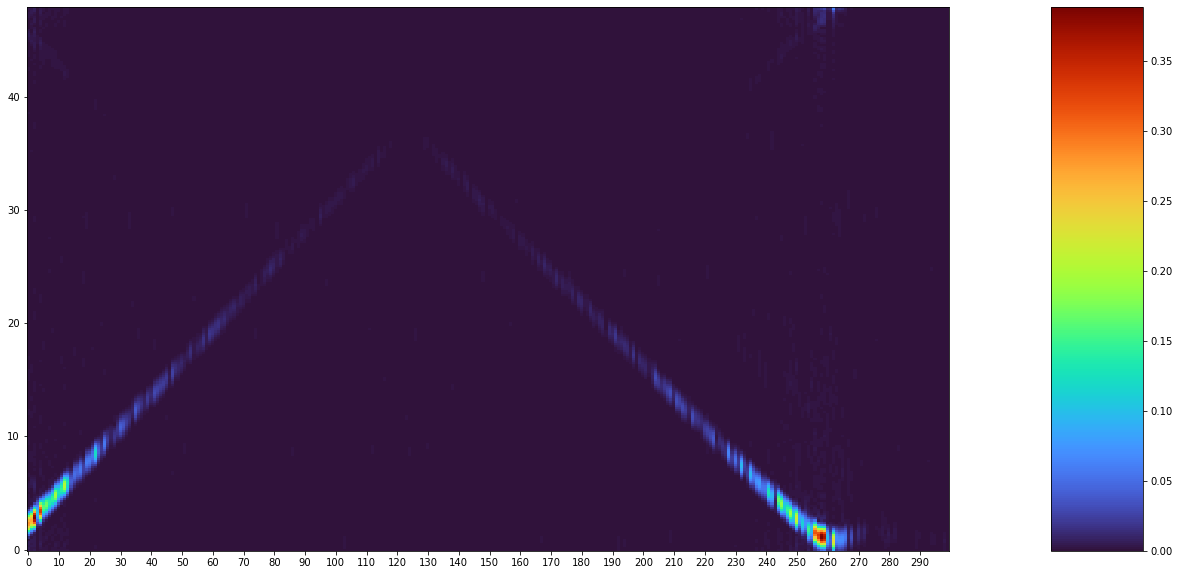

In [25]:
%matplotlib inline
fig,[ax,cax] = plt.subplots(1,2, gridspec_kw={"width_ratios":[10,1]}, figsize=[20,10])
ax.clear()
cmap = mpl.cm.get_cmap('turbo')
norm = mpl.colors.Normalize(vmin=0, vmax=np.max(Range_spectrum_history))
cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
levels = np.linspace(0.0, np.max(Range_spectrum_history), 100)
ax.pcolormesh(np.arange(0,FRAME_NUMBER),range_bin,np.array(Range_spectrum_history).T, cmap=cmap, norm=norm, shading='nearest')
_ = ax.set_xticks(np.arange(0,FRAME_NUMBER,10))

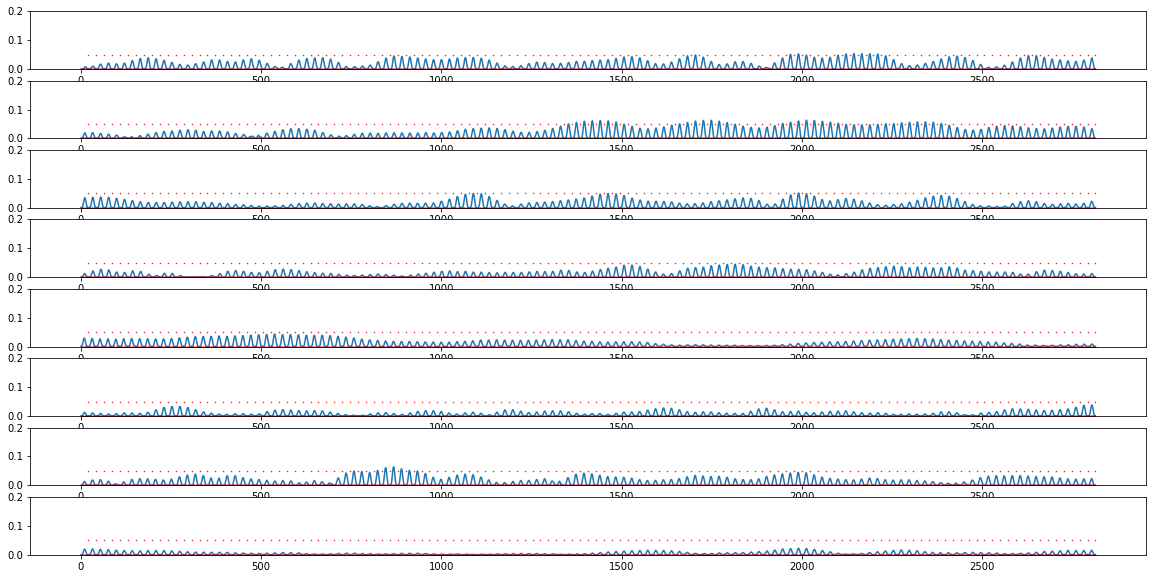

0.020554697733698033


In [16]:
column_plots = 1
row_plots = 8
fig,ax = plt.subplots(row_plots,column_plots,figsize=[20,10])
from_second_number = 20
separator = np.zeros(len(Target_info_list[0].print[:,0,0]))
separator[-1] = 0.05
separator_list = []
for i in range(len(Target_info_list[0].print[0,:,0])):
    separator_list.append(separator)
separator_list = np.array(separator_list).reshape((1,-1))[0,:]

for col in range(column_plots):
    for row in range(row_plots):
        data = Target_info_list[row + row_plots*col + from_second_number].print[:,:,0].T.reshape((1,-1))[0,:]
        ax[row].set_ylim(0,0.2)
        ax[row].plot(data)
        ax[row].plot(separator_list[:],'ro',markersize=0.5)
plt.show()
peak_avg = sum(np.max(Target_info_list[from_second_number+4].print[:,:,0],axis=0))/CHIRPS_PER_FRAME
print(peak_avg)

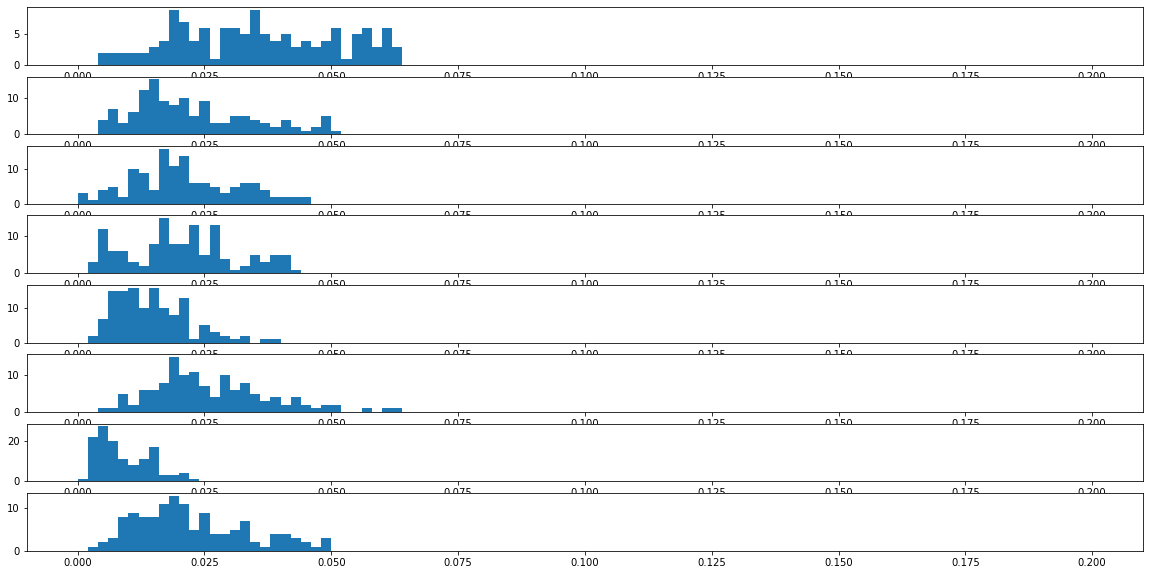

11.05418282770968


In [17]:
column_plots = 1
row_plots = 8
fig,ax = plt.subplots(row_plots,column_plots,figsize=[20,10])
from_second_number = 21
separator = np.zeros(len(Target_info_list[0].print[:,0,0]))
separator[-1] = 0.05
separator_list = []
for i in range(len(Target_info_list[0].print[0,:,0])):
    separator_list.append(separator)
separator_list = np.array(separator_list).reshape((1,-1))[0,:]

for col in range(column_plots):
    for row in range(row_plots):
        data = np.max(Target_info_list[row + row_plots*col + from_second_number].print[:,:,0],axis=0).T.reshape((1,-1))[0,:]
        ax[row].hist(data,bins=100,range=(0,0.2),density=False)
plt.show()
print(Target_info_list[from_second_number].location[0])

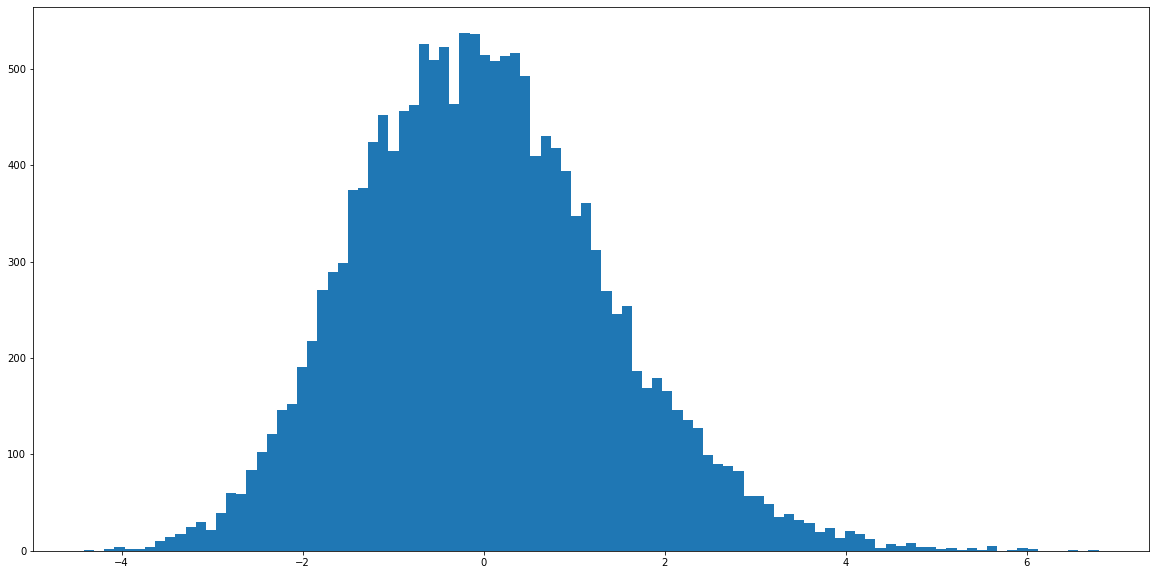

In [18]:
fig,ax = plt.subplots(1,1,figsize=[20,10])
peak_collection = []
for target in Target_info_list:
    peak_strength = np.max(target.print[:,:,0],axis=0)*target.location[0]**2
    peak_strength_mean = np.sum(peak_strength)/CHIRPS_PER_FRAME
    peak_collection.append(peak_strength-peak_strength_mean)
peak_collection = np.array(peak_collection).reshape((1,-1))
_=ax.hist(peak_collection[0,:],bins=100)

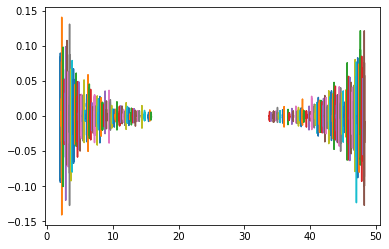

In [19]:

frame_counter = 0
frame_time = np.linspace(0,PULSE_REPETITION_INTERVAL*CHIRPS_PER_FRAME,CHIRPS_PER_FRAME).reshape((CHIRPS_PER_FRAME,1))
frame_time_list = frame_time.reshape((CHIRPS_PER_FRAME,1))
for target_presence in Target_presence_list:
    if target_presence:
        frame_time_list = np.append(frame_time_list,frame_time+FRAME_REP_INTERVAL*frame_counter,axis=1)
    frame_counter += 1
frame_time_list = frame_time_list[:,1:]

fig,ax = plt.subplots(1,1)
valid_frames = sum(Target_presence_list)
for idx in range(valid_frames):
    ax.plot(frame_time_list[:,idx],np.real(Target_info_list[idx].doppler_mark[:,0]))

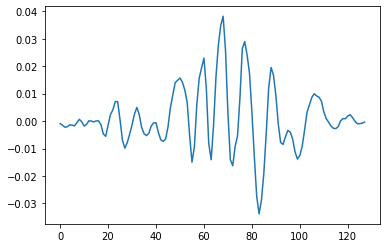

In [20]:
import pywt
t = np.arange(0,128)
sweep = np.linspace(0,2,200)
y = np.real(np.real(Target_info_list[23].doppler_mark[:,0]))#np.sin(2*np.pi*t*(1+sweep)/50)
plt.plot(y)

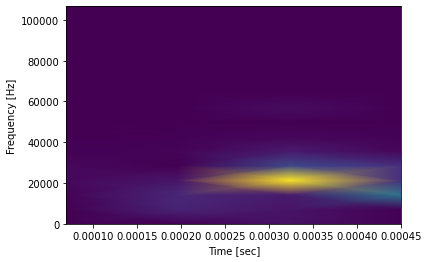

In [21]:
f, t, Sxx = spectrogram(y, SAMPLE_FREQUENCY, nperseg=30)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [22]:
print(Target_presence_list)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [23]:

print(sum(Target_presence_list[0:215]))

99


/home/coppolr/Desktop/Classification-Radar/env/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


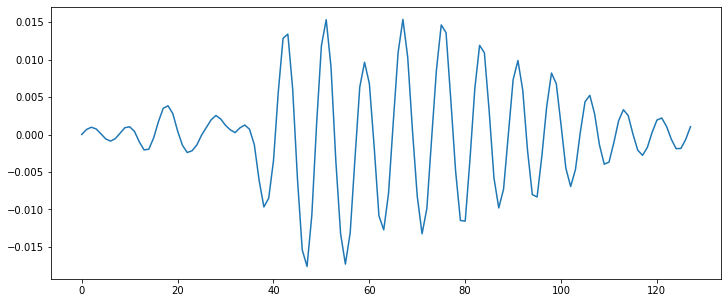

In [24]:
fig,ax = plt.subplots(1,1, figsize=[12,5])
#for frame in np.arange(from_second_number,from_second_number+1):
ax.plot(Target_info_list[97].doppler_mark[:,0])

#plt.savefig('biking_boresight_test_1.png') 